In [1]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json
import math
import numpy as np
from bokeh.io import show, output_file
from bokeh.plotting import figure

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
import pandas as pd

from bokeh.models import HoverTool
from numpy import histogram, linspace

%matplotlib inline
%config IPCompleter.greedy=True

pd.set_option('display.max_colwidth', -1)

In [2]:
data_dir='/Users/genie/dev/projects/github/network_analysis_ticket_to_ride/data/'
destinations_path = os.path.join(data_dir,'destinations.txt')
routes_path = os.path.join(data_dir,'trainroutes.txt')
output_dir='/Users/genie/dev/projects/github/network_analysis_ticket_to_ride/output/'

In [3]:
pattern = re.compile('\\w+')

In [4]:
Gm = nx.MultiGraph()

In [5]:
# functions

# function to calculate points from segment length
def points(distance):
    x = [0, 1, 2, 4, 7, 0, 15, 0, 21]
    return x[distance]

def inverse_weight(distance):
    return(1/distance)

# distance of path p in graph g
def distance_of_path(g, p):
    d = sum([g.edges[p[e],p[e+1]]['distance'] for e in range(len(p)-1)])
    return d

# points of path p in graph g
def points_of_path(g, p):
    d = sum([g.edges[p[e],p[e+1]]['points'] for e in range(len(p)-1)])
    return d

# return all paths between u and v in graph g up to distance min(u,v)+2
def alternate_scoring_paths_with_cutoff(g, u, v, cutoff):
    sp_length = nx.shortest_path_length(g,u,v)
    paths = nx.all_simple_paths(g, u, v, cutoff=sp_length+2)
    return list(paths)

In [6]:
# construct graph

Gm.clear()

with open(routes_path) as f:
    for line in f:
        city1, city2, distance, route_type, color, is_multi = pattern.findall(line)
        distance = int(distance)
        if(Gm.has_edge(city1,city2)==False):
            Gm.add_edge(city1, city2, key=0, distance=distance, route_type=route_type, color=color, points=points(distance), 
                   weight=distance, importance=0)

G = nx.Graph(Gm)

## Structure

In [7]:
from bokeh.models import Range1d, Plot
from bokeh.models.graphs import from_networkx
from bokeh.models.graphs import NodesAndLinkedEdges
from bokeh.models.annotations import Title
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.plotting import figure, show, save
from bokeh.io import output_file, output_notebook
from bokeh.models import Div
from bokeh.layouts import gridplot, column

#output_notebook()
output_file(output_dir + 'node_network.html', mode='inline')

# normalize node size
degree_list = [G.degree[n] for n in G.nodes(data=False)]
start = 10
end = 25
min_ex = np.min(degree_list)
max_ex = np.max(degree_list)
degree_dict = {}
for n,v in sorted(Gm.degree, key=lambda x: x[1], reverse=True):
    norm_v = ((v-min_ex)/(max_ex-min_ex)) * (end-start) + start
    degree_dict[n] = norm_v

# Set node attributes
#nx.set_node_attributes(Gm, 'node_color', node_color)
nx.set_node_attributes(Gm, degree_dict, 'node_size')

# We could use figure here but don't want all the axes and titles
plot = Plot(x_range=Range1d(-2, 2), y_range=Range1d(-2 ,2), title=None) #title=Title(text="Network"))
#plot.title.text="Network"
plot.width = 900;

# Create a Bokeh graph from the NetworkX input using nx.spring_layout
graph = from_networkx(Gm, nx.spring_layout, scale=1.8, center=(0,0))
plot.renderers.append(graph)

# Blue circles for nodes, and light grey lines for edges
graph.node_renderer.glyph = Circle(size='node_size', fill_color='#2b83ba')
graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=2)

# green hover for both nodes and edges
graph.node_renderer.hover_glyph = Circle(size=25, fill_color='#abdda4')
graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

# When we hover over nodes, highlight adjecent edges too
graph.inspection_policy = NodesAndLinkedEdges()

plot.add_tools(HoverTool(tooltips="@index"))

# Add a title for the entire visualization using Div
plot_html = """<h3>Chart 1: Ticket-to-Ride Network Structure</h3>
Note: Nodes represent cities and edges represent tracks between cities, node size is proportional to the degree
<br>
<i>Hover over each node for more information</i>
"""
plot_subtitle = Div(width=800, text=plot_html)

# Visualize
show(column(plot_subtitle, plot))

#show(plot)
#save(plot)

### Degree & Weights Distribution

In [8]:
from collections import Counter 
degree_count = Counter(['Degree-' + str(G.degree[n]) for n in G.nodes(data=False)]) 
weights_count = Counter(['Weight-' + str(d['weight']) for u,v,d in G.edges(data=True)])

from math import pi
import pandas as pd
from bokeh.plotting import figure, show, save
from bokeh.io import output_file, output_notebook
from bokeh.palettes import Category20c
from bokeh.transform import cumsum
from bokeh.layouts import row, column
from bokeh.models import Div

output_file(output_dir + "degree_weight_dist.html")
#output_notebook()

degrees = dict(degree_count)
p1_data = pd.Series(degrees).reset_index(name='value').rename(columns={'index':'degree'})
p1_data['angle'] = p1_data['value']/p1_data['value'].sum() * 2*pi
p1_data['pct_share'] = round((p1_data['value']/p1_data['value'].sum())*100,2)
p1_data['color'] = Category20c[len(degrees)]

p1 = figure(plot_height=350, plot_width=500, title="2a-Degree Distribution", toolbar_location=None,
           tools="hover", tooltips="@degree: @value (@pct_share%)", x_range=(-0.5, 1.0))

p1.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='degree', source=p1_data)

p1.axis.axis_label=None
p1.axis.visible=False
p1.grid.grid_line_color = None
p1.legend.location = "bottom_right"

#show(p1)

weights = dict(weights_count)
p2_data = pd.Series(weights).reset_index(name='value').rename(columns={'index':'weight'})
p2_data['angle'] = p2_data['value']/p2_data['value'].sum() * 2*pi
p2_data['pct_share'] = round((p2_data['value']/p2_data['value'].sum())*100,2)
p2_data['color'] = Category20c[len(weights)]

p2 = figure(plot_height=350, plot_width=500, title="2b-Weight Distribution", toolbar_location=None,
           tools="hover", tooltips="@weight: @value (@pct_share%)", x_range=(-0.5, 1.0))

p2.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='weight', source=p2_data)

p2.axis.axis_label=None
p2.axis.visible=False
p2.grid.grid_line_color = None
p2.legend.location = "bottom_right"

# Add a title for the entire visualization using Div
html = """<h3>Chart 2: Degree and Weight Distribution</h3>
Note: Each pie segment represents the number of cities with a corresponding degree or weight.
<br>
<i>Hover over each pie segment for more information</i>
"""
subtitle = Div(width=800, text=html)
show(column(subtitle, row(p1, p2)))

#show(p2)
#show(row(p1, p2))


In [9]:
# #histogram of degrees for all nodes
# degree_list = [G.degree[n] for n in G.nodes(data=False)]

# plt.hist(degree_list, label="Degrees")
# plt.legend(loc='upper right')

# #histogram of weights for all nodes
# weights_list = [d['weight'] for u,v,d in G.edges(data=True)]

# plt.hist(weights_list, label="Weights")
# plt.legend(loc='upper right')

In [10]:
# from IPython.display import display, HTML
# display(HTML(degree_df.head(10).to_html(index=False)))
# display(HTML(degree_df.tail(10).sort_values(by='degree',ascending=True).to_html(index=False)))

In [11]:
degree_df = pd.DataFrame([[n,v] for n,v in sorted(Gm.degree, key=lambda x: x[1], reverse=True)], columns=['city','degree'])


In [12]:
# Top-10 cities with high degree
for index, row in degree_df.head(10).iterrows():
    print('{} - {}'.format(row['city'],row['degree']))

Paris - 7
Kyiv - 6
Frankfurt - 6
Pamplona - 5
Marseille - 5
Sevastopol - 5
Constantinople - 5
Bucuresti - 5
Wilno - 5
Warszawa - 5


In [13]:
# Top-10 cities with low degree
for index, row in degree_df.tail(10).sort_values(by='degree',ascending=True).iterrows():
    print('{} - {}'.format(row['city'],row['degree']))

Edinburgh - 1
Lisboa - 2
Cadiz - 2
Stockholm - 2
Kobenhavn - 2
Smolensk - 3
Riga - 3
Palermo - 3
Danzig - 3
Brindisi - 3


### Basic Stats

In [14]:
# fraction of nodes with degree < 5
len(degree_df[degree_df.degree<5])/len(degree_df)*100

72.3404255319149

In [15]:
# fraction of nodes with degree < 4
len(degree_df[degree_df.degree<4])/len(degree_df)*100

40.42553191489361

In [16]:
# fraction of nodes with degree < 3
len(degree_df[degree_df.degree<3])/len(degree_df)*100

10.638297872340425

In [17]:
nx.radius(G)

5

In [18]:
nx.diameter(G)

9

In [19]:
nx.center(G)

['Berlin', 'Venezia', 'Munchen']

In [20]:
nx.periphery(G)

['Lisboa', 'Cadiz', 'Edinburgh', 'Erzurum', 'Sochi', 'Rostov', 'Moskva']

In [21]:
ecc = nx.eccentricity(G)
ecc = dict(sorted(ecc.items(), key=lambda x: x[1], reverse=True))
print(json.dumps(ecc, indent=4))

{
    "Lisboa": 9,
    "Cadiz": 9,
    "Edinburgh": 9,
    "Erzurum": 9,
    "Sochi": 9,
    "Rostov": 9,
    "Moskva": 9,
    "Madrid": 8,
    "Barcelona": 8,
    "Brest": 8,
    "Dieppe": 8,
    "London": 8,
    "Angora": 8,
    "Sevastopol": 8,
    "Constantinople": 8,
    "Bucuresti": 8,
    "Kharkov": 8,
    "Smolensk": 8,
    "Petrograd": 8,
    "Sofia": 8,
    "Pamplona": 7,
    "Marseille": 7,
    "Paris": 7,
    "Bruxelles": 7,
    "Amsterdam": 7,
    "Smyrna": 7,
    "Kyiv": 7,
    "Wilno": 7,
    "Budapest": 7,
    "Riga": 7,
    "Stockholm": 7,
    "Palermo": 7,
    "Athina": 7,
    "Kobenhavn": 7,
    "Sarajevo": 7,
    "Brindisi": 7,
    "Warszawa": 6,
    "Danzig": 6,
    "Essen": 6,
    "Wien": 6,
    "Zagrab": 6,
    "Roma": 6,
    "Frankfurt": 6,
    "Zurich": 6,
    "Berlin": 5,
    "Venezia": 5,
    "Munchen": 5
}


In [22]:
# listing paths with length as diameter from all peripheries
diameter = nx.diameter(G)
for n in nx.periphery(G):
    paths = nx.shortest_path(G,source=n)
    for k,v in paths.items():
        if(len(v)-1==diameter):
            print("-".join(v))

Lisboa-Madrid-Barcelona-Marseille-Roma-Palermo-Smyrna-Angora-Erzurum-Sochi
Lisboa-Madrid-Barcelona-Marseille-Roma-Palermo-Smyrna-Constantinople-Sevastopol-Rostov
Lisboa-Madrid-Pamplona-Paris-Frankfurt-Essen-Kobenhavn-Stockholm-Petrograd-Moskva
Cadiz-Madrid-Barcelona-Marseille-Roma-Palermo-Smyrna-Angora-Erzurum-Sochi
Cadiz-Madrid-Barcelona-Marseille-Roma-Palermo-Smyrna-Constantinople-Sevastopol-Rostov
Cadiz-Madrid-Pamplona-Paris-Frankfurt-Essen-Kobenhavn-Stockholm-Petrograd-Moskva
Edinburgh-London-Dieppe-Paris-Marseille-Roma-Palermo-Smyrna-Angora-Erzurum
Edinburgh-London-Amsterdam-Essen-Berlin-Warszawa-Kyiv-Bucuresti-Sevastopol-Sochi
Erzurum-Angora-Smyrna-Palermo-Roma-Marseille-Paris-Dieppe-London-Edinburgh
Sochi-Erzurum-Angora-Smyrna-Palermo-Roma-Marseille-Barcelona-Madrid-Lisboa
Sochi-Erzurum-Angora-Smyrna-Palermo-Roma-Marseille-Barcelona-Madrid-Cadiz
Sochi-Sevastopol-Bucuresti-Budapest-Wien-Berlin-Essen-Amsterdam-London-Edinburgh
Rostov-Sevastopol-Constantinople-Smyrna-Palermo-Roma-M

### Destination Card Points Distribution

In [23]:
# construct destination card points list
card_points_list=list()
with open(destinations_path) as f:
    for line in f:
        source, destination, card_points = pattern.findall(line)
        card_points=int(card_points)
        card_points_list.append(card_points)

## bar chart

from collections import Counter 
#card_points = [row['card_points'] for idx,row in destinations_df.iterrows()]
col_count = Counter(card_points_list) 

from bokeh.plotting import figure, show, save
from bokeh.io import output_file, output_notebook
from bokeh.models import HoverTool
from bokeh.layouts import row, column
from bokeh.models import Div

#output_notebook()
output_file(output_dir + "destination_card_points_dist.html")

labels = [str(key) for key,value in sorted(col_count.items())]
values = [value for key,value in sorted(col_count.items())]
pct_share = [round(value/len(card_points_list)*100,2) for key,value in sorted(col_count.items())]
source = ColumnDataSource(data = dict(labels = labels, values= values, pct_share=pct_share))
                          
p = figure(x_range=labels, plot_height=350, title=None)
p.vbar(x="labels", top="values", width=0.9, source=source)

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.add_tools(HoverTool(tooltips=[("card points","@labels"),("count","@values (@pct_share%)")]))                          

#show(p)

# Add a title for the entire visualization using Div
html = """<h3>Chart 3: Destination Card Points Distribution</h3>
<i>Hover over each bar for more information</i>
"""
subtitle = Div(width=800, text=html)
show(column(subtitle, p))


### Importance of certain cities

In [24]:
# degree centrality
dc = nx.degree_centrality(G)
top_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True)[:5])

for k,v in top_dc.items():
    print('{} - {}'.format(k,round(v,4)))

Paris - 0.1522
Kyiv - 0.1304
Frankfurt - 0.1304
Pamplona - 0.1087
Marseille - 0.1087


In [25]:
# closeness centrality
cc = nx.closeness_centrality(G, distance='weight')
top_cc = dict(sorted(cc.items(), key=lambda x: x[1], reverse=True)[:5])

for k,v in top_cc.items():
    print('{} - {}'.format(k,round(v,4)))

Wien - 0.1201
Munchen - 0.1173
Budapest - 0.117
Zagrab - 0.1168
Venezia - 0.1159


In [26]:
# betweenness centrality
bc = nx.betweenness_centrality(G, weight='weight')
top_bc = dict(sorted(bc.items(), key=lambda x: x[1], reverse=True)[:5])
#print(json.dumps(top_bc, indent=4))

for k,v in top_bc.items():
    print('{} - {}'.format(k,round(v,4)))

Frankfurt - 0.2061
Wien - 0.1855
Budapest - 0.1769
Venezia - 0.1752
Munchen - 0.1621


In [27]:
# convert multigraph to simple graph            
G = nx.Graph(Gm)

# node clustering co-efficient for each city
# definition: http://wandora.org/wiki/Clustering_coefficient
ccoef = nx.clustering(G)
ccoef = dict(sorted(ccoef.items(), key=lambda x: x[1], reverse=True))
print(json.dumps(ccoef, indent=4))

{
    "Lisboa": 1.0,
    "Cadiz": 1.0,
    "Barcelona": 0.6666666666666666,
    "Brest": 0.6666666666666666,
    "Sochi": 0.6666666666666666,
    "Bruxelles": 0.5,
    "Pamplona": 0.4,
    "Madrid": 0.3333333333333333,
    "Dieppe": 0.3333333333333333,
    "Amsterdam": 0.3333333333333333,
    "Erzurum": 0.3333333333333333,
    "Angora": 0.3333333333333333,
    "Rostov": 0.3333333333333333,
    "Smolensk": 0.3333333333333333,
    "Riga": 0.3333333333333333,
    "Palermo": 0.3333333333333333,
    "Sofia": 0.3333333333333333,
    "Danzig": 0.3333333333333333,
    "Essen": 0.3333333333333333,
    "Zagrab": 0.3333333333333333,
    "Sarajevo": 0.3333333333333333,
    "Brindisi": 0.3333333333333333,
    "Zurich": 0.3333333333333333,
    "Marseille": 0.3,
    "Sevastopol": 0.3,
    "Constantinople": 0.3,
    "Bucuresti": 0.3,
    "Wilno": 0.3,
    "Warszawa": 0.3,
    "Budapest": 0.3,
    "Berlin": 0.3,
    "Paris": 0.2857142857142857,
    "Frankfurt": 0.26666666666666666,
    "Kyiv": 0.2,
   

In [28]:
# measuring each node importance by change in connectivity, efficiency

G_avg_node_connectivity = nx.average_node_connectivity(G)
G_avg_sp_length = nx.average_shortest_path_length(G, weight='weight') 
G_global_efficiency = nx.global_efficiency(G)
G_local_efficiency = nx.local_efficiency(G)

temp=list()
for u,d in G.nodes(data=True):
    H = nx.Graph(G)
    H.remove_node(u)
    H_avg_node_connectivity = nx.average_node_connectivity(H)
    #H_avg_sp_length = nx.average_shortest_path_length(H, weight='weight') 
    H_global_efficiency = nx.global_efficiency(H)
    H_local_efficiency = nx.local_efficiency(H)
    connectivity_change = round((H_avg_node_connectivity-G_avg_node_connectivity)/G_avg_node_connectivity * 100, 2)
    global_efficiency_change = round((H_global_efficiency-G_global_efficiency)/G_global_efficiency*100, 2)
    local_efficiency_change = round((H_local_efficiency-G_local_efficiency)/G_local_efficiency*100,2)
    temp.append((u,connectivity_change,global_efficiency_change,local_efficiency_change))

node_importance_df = pd.DataFrame.from_records(temp, columns=['city','avg_connectivity_change',
                                                              'global_efficiency_change','local_efficiency_change'])
del temp

node_importance_df.head()

,city,avg_connectivity_change,global_efficiency_change,local_efficiency_change
0,Lisboa,2.81,1.43,-9.99
1,Cadiz,2.81,1.43,-9.99
2,Madrid,-1.60,-4.30,-10.51
3,Barcelona,0.00,0.41,-4.36
4,Pamplona,-7.08,-1.03,-8.47


### Importance of certain route segments

In [29]:
# edge-betweenness centrality
ebc = nx.edge_betweenness_centrality(G,weight='weight')
top_ebc = dict(sorted(ebc.items(), key=lambda x: x[1], reverse=True)[:5])

for k,v in top_ebc.items():
    print('{} - {}'.format(k,v))

('Budapest', 'Wien') - 0.14287916831857628
('Zagrab', 'Venezia') - 0.1316726135412537
('Wien', 'Munchen') - 0.11743976036297961
('Frankfurt', 'Munchen') - 0.11262499449363465
('Bucuresti', 'Budapest') - 0.11036518215056604


In [30]:
# measuring each edge importance by change in connectivity, efficiency
temp=list()
for u,v,d in G.edges(data=True):
    H = nx.Graph(G)
    H.remove_edge(u,v)
    H_avg_node_connectivity = nx.average_node_connectivity(H)
    H_global_efficiency = nx.global_efficiency(H)
    H_local_efficiency = nx.local_efficiency(H)
    connectivity_change = round((H_avg_node_connectivity-G_avg_node_connectivity)/G_avg_node_connectivity * 100, 2)
    global_efficiency_change = round((H_global_efficiency-G_global_efficiency)/G_global_efficiency*100, 2)
    local_efficiency_change = round((H_local_efficiency-G_local_efficiency)/G_local_efficiency*100,2)
    temp.append(('{}-{}'.format(u,v),connectivity_change,global_efficiency_change,local_efficiency_change))

edge_importance_df = pd.DataFrame.from_records(temp, columns=['segment','avg_connectivity_change',
                                                              'global_efficiency_change','local_efficiency_change'])
del temp

edge_importance_df.head()

,segment,avg_connectivity_change,global_efficiency_change,local_efficiency_change
0,Lisboa-Cadiz,-0.10,-0.14,-12.89
1,Lisboa-Madrid,-0.10,-0.57,-11.90
2,Cadiz-Madrid,-0.10,-0.57,-11.90
3,Madrid-Barcelona,-1.41,-0.23,-0.25
4,Madrid-Pamplona,-1.41,-0.89,-2.50


### Route Profitability & Alternate Scoring Strategies

In [31]:
# construct shortest paths of destinations
temp=list()
with open(destinations_path) as f:
    for line in f:
        source, destination, card_points = pattern.findall(line)
        card_points=int(card_points)
        p1=list()
        points1=0
        distance1=0
        length1=0
        for p in nx.all_shortest_paths(G,source,destination,weight='weight'):
            _points=points_of_path(G,p)
            if(_points>points1):
                points1=_points
                distance1=distance_of_path(G,p)
                p1=p
                length1=len(p)
        total_points=card_points+points1
        temp.append((source,destination,card_points,length1,distance1,total_points,'-'.join(p1)))
        
sp_df = pd.DataFrame.from_records(temp, columns=['source','destination','card_points',
                                                           'sp_length','sp_cost','sp_total_points','sp_path'])
del temp

#  calculate points-per-capita
sp_df['sp_points_per_capita'] = sp_df.apply(lambda row: round(row['sp_total_points']/row['sp_cost'],2), axis=1)

# connectivity
sp_df['connectivity'] = sp_df.apply(lambda row: nx.edge_connectivity(G,row['source'],row['destination']), axis=1)

In [32]:
# sp_df.sort_values(['sp_total_points'],ascending=False).head(10)

from IPython.display import display, HTML
display(HTML(sp_df.sort_values(['sp_total_points'],ascending=False).head(5).to_html(index=False)))
# display(HTML(degree_df.tail(10).sort_values(by='degree',ascending=True).to_html(index=False)))

source,destination,card_points,sp_length,sp_cost,sp_total_points,sp_path,sp_points_per_capita,connectivity
Palermo,Moskva,20,7,20,54,Palermo-Smyrna-Constantinople-Bucuresti-Kyiv-Smolensk-Moskva,2.70,3
Kobenhavn,Erzurum,21,8,21,53,Kobenhavn-Essen-Berlin-Wien-Budapest-Bucuresti-Sevastopol-Erzurum,2.52,2
Cadiz,Stockholm,21,8,21,50,Cadiz-Madrid-Pamplona-Paris-Frankfurt-Essen-Kobenhavn-Stockholm,2.38,2
Brest,Petrograd,20,7,20,50,Brest-Paris-Frankfurt-Berlin-Warszawa-Wilno-Petrograd,2.50,3
Lisboa,Danzig,20,7,20,50,Lisboa-Madrid-Pamplona-Paris-Frankfurt-Berlin-Danzig,2.50,2


In [33]:
# compare alternate paths between given cities
temp = list()
u = 'Palermo'
v = 'Moskva'
cutoff = nx.shortest_path_length(G, u, v) + 2
paths = alternate_scoring_paths_with_cutoff(G, u, v, cutoff)
for p in paths:
    length1 = len(p)
    cost1 = distance_of_path(G, p)
    points1 = int(sp_df[(sp_df['source']==u) & (sp_df['destination']==v)]['card_points'])
    points2 = points_of_path(G, p)
    total_points = points1 + points2
    per_capita=round(total_points/cost1,2)
    temp.append((p,length1,cost1,total_points,per_capita))

temp_df = pd.DataFrame.from_records(temp,columns=['path','path_length','path_cost','path_total_points','path_points_per_capita'])
del temp

# temp_df.sort_values(['path_points_per_capita'],ascending=False).head(5)
display(HTML(temp_df.sort_values(['path_points_per_capita'],ascending=False).head(5).to_html(index=False)))

path,path_length,path_cost,path_total_points,path_points_per_capita
"[Palermo, Smyrna, Constantinople, Sevastopol, Rostov, Kharkov, Moskva]",7,22,60,2.73
"[Palermo, Smyrna, Constantinople, Bucuresti, Kyiv, Smolensk, Moskva]",7,20,54,2.70
"[Palermo, Smyrna, Constantinople, Bucuresti, Kyiv, Kharkov, Moskva]",7,23,62,2.70
"[Palermo, Smyrna, Constantinople, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",8,29,77,2.66
"[Palermo, Smyrna, Athina, Sarajevo, Budapest, Kyiv, Kharkov, Moskva]",8,29,77,2.66


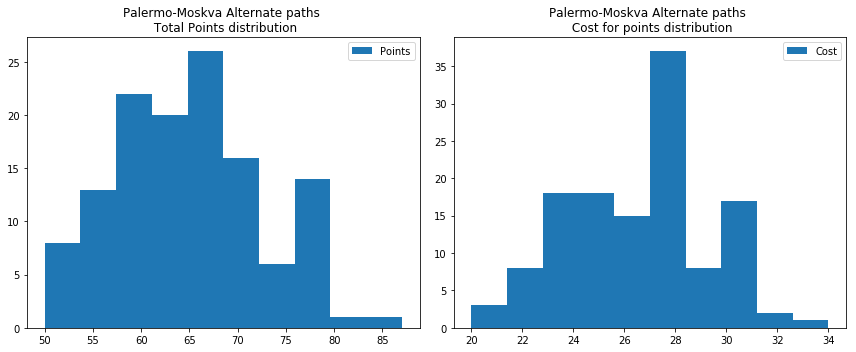

In [34]:
#histogram of all points for all alternate paths

fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist([temp_df['path_total_points']], label="Points")
plt.legend(loc='upper right')
plt.title('Palermo-Moskva Alternate paths \n Total Points distribution')

plt.subplot(1, 2, 2)
plt.hist([temp_df['path_cost']], label="Cost")
plt.legend(loc='upper right')
plt.title('Palermo-Moskva Alternate paths \n Cost for points distribution')

plt.tight_layout()

In [35]:
temp_df.sort_values(['path_total_points'],ascending=False).head(5)

,path,path_length,path_cost,path_total_points,path_points_per_capita
23,"[Palermo, Smyrna, Constantinople, Sevastopol, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",9,34,87,2.56
13,"[Palermo, Smyrna, Angora, Constantinople, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",9,32,81,2.53
45,"[Palermo, Smyrna, Constantinople, Bucuresti, Budapest, Kyiv, Wilno, Petrograd, Moskva]",9,31,79,2.55
74,"[Palermo, Smyrna, Athina, Sarajevo, Zagrab, Budapest, Kyiv, Kharkov, Moskva]",9,31,79,2.55
71,"[Palermo, Smyrna, Athina, Sarajevo, Budapest, Kyiv, Wilno, Petrograd, Moskva]",9,31,79,2.55


In [36]:
temp_df.sort_values(['path_points_per_capita'],ascending=False).head(5)

,path,path_length,path_cost,path_total_points,path_points_per_capita
29,"[Palermo, Smyrna, Constantinople, Sevastopol, Rostov, Kharkov, Moskva]",7,22,60,2.73
47,"[Palermo, Smyrna, Constantinople, Bucuresti, Kyiv, Smolensk, Moskva]",7,20,54,2.70
46,"[Palermo, Smyrna, Constantinople, Bucuresti, Kyiv, Kharkov, Moskva]",7,23,62,2.70
42,"[Palermo, Smyrna, Constantinople, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",8,29,77,2.66
68,"[Palermo, Smyrna, Athina, Sarajevo, Budapest, Kyiv, Kharkov, Moskva]",8,29,77,2.66


### Route Blocking Strategies

In [37]:
# list(nx.all_node_cuts(G))

# # calc edge importance from min edge cut's
# for idx,row in destinations_df.iterrows():
#     for min_cut in list(nx.minimum_edge_cut(G,row['source'],row['destination'])):
#         u, v = min_cut
#         G.edges[u,v]['importance']+=1

# for u, v, d in sorted(G.edges(data=True), key=lambda x: x[2]['importance'], reverse=True)[:10]:
#     print('{u}-{v} {imp}'.format(u=u, v=v, imp=d['importance']))
    
# for min_cut in list(nx.minimum_node_cut(G,'Palermo','Moskva')):
#     print(min_cut)
    
# # calc node importance from min node cut's

# temp=list()
# with open(destinations_path) as f:
#     for line in f:
#         source, destination, card_points = pattern.findall(line)
#         card_points=int(card_points)
#         temp.append((source,destination,card_points))
        
# destinations_df = pd.DataFrame.from_records(temp, columns=['source','destination','card_points'])
# del temp

# from collections import Counter 

# city_list = []
# for idx,row in destinations_df.iterrows():
#     for min_cut in list(nx.minimum_node_cut(G,row['source'],row['destination'])):
#         city_list.append(min_cut)

# city_count = Counter(city_list) 
# city_count.most_common(10)

# from networkx.algorithms.connectivity import local_node_connectivity
# local_node_connectivity(G, 'Cadiz', 'Edinburgh')